**<p style="text-align: center; font-size: 40px; font-family: 'Times New Roman';">FINDING HEAT FROM VELOCITY</p>**

**<p style="text-align: center; font-size: 20px; font-family: 'Times New Roman';">Amber Parker, Ilana Keselman, Mike Yan, Takumu Hamanaka</p>**

## Velocity Calculations

**Air density in Earth's atmosphere (below 100 km)**

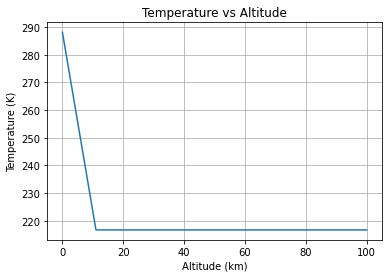

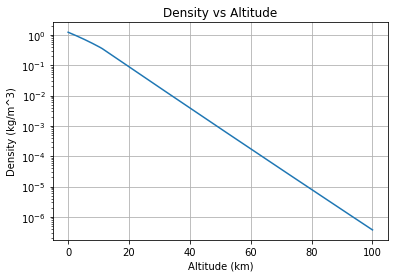

In [10]:
import numpy as np
import matplotlib.pyplot as plt

h_g = np.linspace(0, 100000, 500)  # Geopotential height from 0 to 100000 m (100 km)

def AtmosphereFunction(h_g):
    
    r_e= 6.371e6                        #earth's radius in meters
    R=287                               #m^2/K-sec, a constant
    g0=9.81                             #m/sec^2, gravity
    T0=288.15                           #degree K
    g_hG = g0 * (r_e / (r_e + h_g))**2  #gravity acceleration based on geopotential height
    h = (r_e / (r_e + h_g)) * h_g      #altitude from geopotenential altitude
    
    if h < 11000:                      #standard atmosphere math below the tropopause (m)
        h0 = 0                          #sea level altitude for comparison
        t0 = 288.15                     #sea level temperature for comparison in K
        P0 = 101325                     #sea level pressure for comparison in Pa
        rho0 = 1.225                    #sea level density for comparison in kg/m^3
        a1 = -6.5 * 10**(-3)                #temperature lapse rate in K/m
        T = T0 + a1 * (h - h0)          #temperature at altitude h
        P = P0 * (T / T0) ** (-g0 / (a1 * R))  #pressure from temperature
        rho = rho0 * (T / T0) ** (-(g0 / (a1 * R) + 1))  #density from temperature
    else:                               #standard atmosphere math above the tropopause (m)
        h0 = 11000                     #altitude at 11 km 
        P0 = 22632                  #pressure at 11 km in Pa
        rho0 = 3639 * 10**(-4)                #density at 11 km in kg/m^3
        T = 216.66                     #temperature is constant above 11 km
        P = P0 * np.exp(-g0 / (R * T) * (h - h0))  #pressure from temperature
        rho = rho0 * np.exp(-(g0 / (R * T) * (h - h0)))  #density from temperature
    
    mu0 = 1.7894e-5                    #viscosity at SL
    a = np.sqrt(1.4 * P/rho)           #speed of sound
    mu = mu0 * (T / T0) ** (1.5) * (T0 + 110.4) / (T + 110.4)  #viscosity from sutherland's formula
    return [h_g, h, T, P, rho, a, mu]

#T vs Altitude plot
T = [AtmosphereFunction(h)[2] for h in h_g]
plt.figure()
plt.plot(h_g / 1000, T)
plt.title('Temperature vs Altitude')
plt.xlabel('Altitude (km)')
plt.ylabel('Temperature (K)')
plt.grid()
plt.show()

#rho vs Altitude plot
rho = [AtmosphereFunction(h)[4] for h in h_g]
plt.figure()
plt.plot(h_g / 1000, rho)
plt.title('Density vs Altitude')
plt.xlabel('Altitude (km)')
plt.ylabel('Density (kg/m^3)')
plt.yscale('log')
plt.grid()
plt.show()

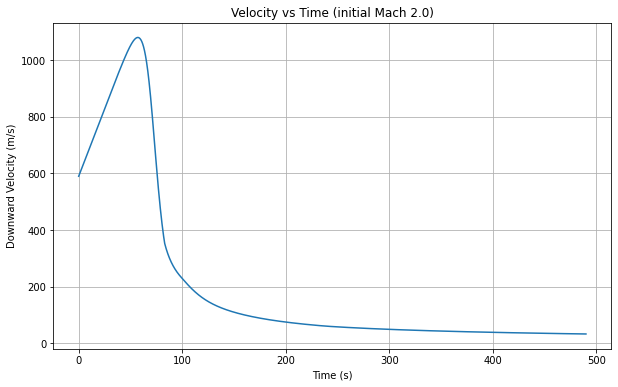

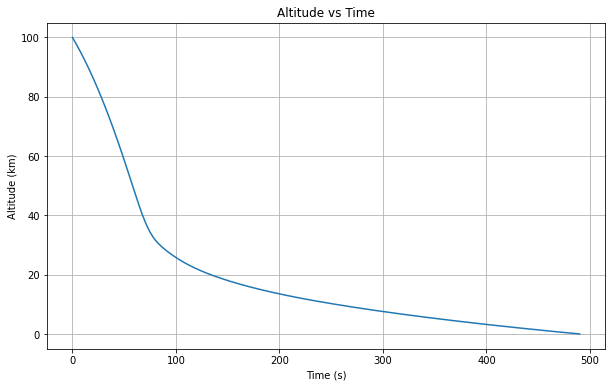

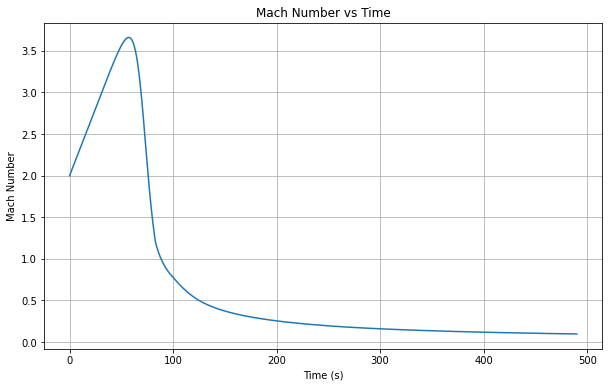

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# 0. USER INPUTS (EASY TO CHANGE)
# -----------------------------------------------------------

# Simulation parameters
mach0 = 2.0       # initial Mach number (downward)
r = 0.1           # sphere radius (m)
m = 1.0           # sphere mass (kg)
dt = 0.05         # time step (s)
h0 = 100000.0     # starting altitude (m)

# -----------------------------------------------------------
# 1. Atmospheric Model Function
# -----------------------------------------------------------

def AtmosphereFunction(h_g):
    r_e = 6.371e6
    R = 287
    g0 = 9.81
    T0 = 288.15

    g_hG = g0 * (r_e / (r_e + h_g))**2
    h = (r_e / (r_e + h_g)) * h_g

    if h < 11000:
        h0 = 0
        T = 288.15 - 6.5e-3 * (h - h0)
        P0 = 101325
        R = 287
        g0 = 9.81
        P = P0 * (T / 288.15) ** (-g0 / (-6.5e-3 * R))
        rho = 1.225 * (T / 288.15) ** (-(g0 / (-6.5e-3 * R) + 1))
    else:
        h0 = 11000
        P0 = 22632
        rho0 = 0.3639
        T = 216.66
        P = P0 * np.exp(-g0 / (R * T) * (h - h0))
        rho = rho0 * np.exp(-g0 / (R * T) * (h - h0))

    a = np.sqrt(1.4 * R * T)
    return g_hG, rho, a


# -----------------------------------------------------------
# 2. Drag Coefficient Function
# -----------------------------------------------------------

def Cd_vs_Mach(M):
    """Empirical Cd vs Mach curve for a smooth sphere."""
    if M < 0.8:
        Cd = 0.47
    elif M < 1.2:
        Cd = 0.47 + 0.6 * (M - 0.8)  # drag rise in transonic region
    elif M < 5.0:
        Cd = 1.0 - 0.1 * (M - 1.2)   # decreasing drag in supersonic regime
    else:
        Cd = 0.6
    return Cd


# -----------------------------------------------------------
# 3. Falling Sphere Simulation
# -----------------------------------------------------------

def drop_sphere(mach0, dt, m, r, h0):
    A = np.pi * r**2
    g, rho, a = AtmosphereFunction(h0)
    v = -mach0 * a  # downward initial velocity

    t = 0.0
    h = h0

    t_list, h_list, v_list, M_list = [t], [h], [v], [abs(v)/a]

    while h > 0 and t < 2000:
        g, rho, a = AtmosphereFunction(h)
        M = abs(v) / a
        Cd = Cd_vs_Mach(M)
        Fd = 0.5 * rho * Cd * A * v**2 * np.sign(v)
        Fg = -m * g
        Fnet = Fg - Fd
        a_net = Fnet / m

        v += a_net * dt
        h += v * dt
        t += dt

        t_list.append(t)
        h_list.append(h)
        v_list.append(v)
        M_list.append(abs(v) / a)

        if h <= 0:
            break

    return np.array(t_list), np.array(h_list), np.array(v_list), np.array(M_list)


# -----------------------------------------------------------
# 4. Run Simulation
# -----------------------------------------------------------

t, h, v, M = drop_sphere(mach0, dt, m, r, h0)

# -----------------------------------------------------------
# 5. Plot Results
# -----------------------------------------------------------

plt.figure(figsize=(10,6))
plt.plot(t, -v)
plt.title(f"Velocity vs Time (initial Mach {mach0})")
plt.xlabel("Time (s)")
plt.ylabel("Downward Velocity (m/s)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(t, h/1000)
plt.title("Altitude vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Altitude (km)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(t, M)
plt.title("Mach Number vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Mach Number")
plt.grid(True)
plt.show()

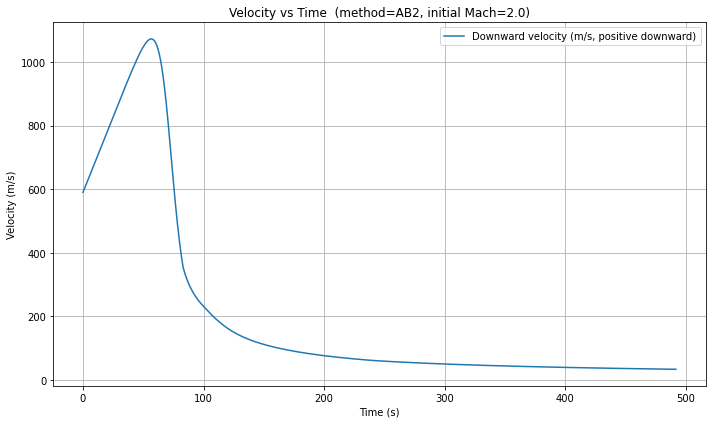

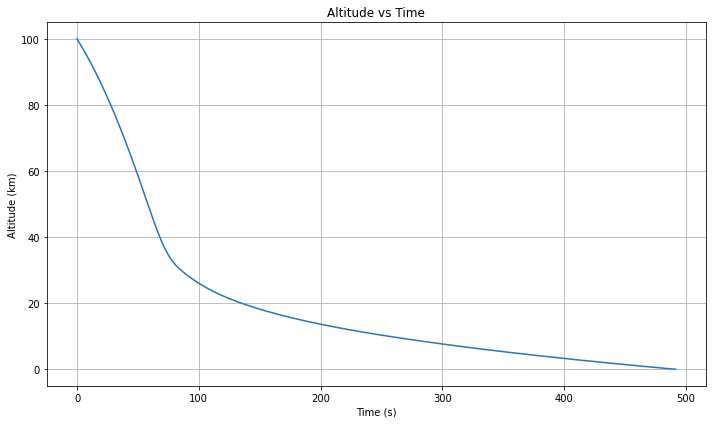

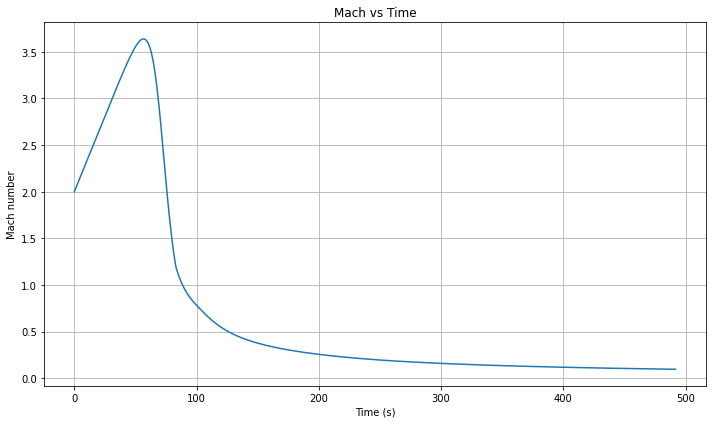

Method: AB2, steps: 9835, simulated time: 491.72 s
Impact velocity (if hit ground): 33.02 m/s downward (Mach at ground: 0.10)


In [15]:
import numpy as np
import matplotlib.pyplot as plt

# =========================
# USER INPUTS (single place)
# =========================
method = "AB2"     # "RK4" or "AB2"
mach0 = 2.0        # initial Mach number (positive toward Earth)
r = 0.1            # sphere radius (m)
m = 1.0            # sphere mass (kg)
dt = 0.05          # time step (s)
h0 = 100000.0      # initial altitude (m)
t_max = 2000.0     # maximum simulated time (s)
# =========================


# -------------------------
# ATMOSPHERE (returns g, rho, a)
# -------------------------
def AtmosphereFunction(h_g):
    # Inputs: geopotential-like height h_g (we use simply geometric h here)
    r_e = 6.371e6
    R = 287.0
    g0 = 9.81
    T0 = 288.15

    # approximate geopotential -> geometric mapping (kept as in earlier model)
    g = g0 * (r_e / (r_e + h_g))**2
    h = (r_e / (r_e + h_g)) * h_g

    # simplified ISA
    if h < 11000:
        T = 288.15 - 6.5e-3 * h
        P0 = 101325.0
        rho0 = 1.225
        a1 = -6.5e-3
        P = P0 * (T / 288.15) ** (-g0 / (a1 * R))
        rho = rho0 * (T / 288.15) ** (-(g0 / (a1 * R) + 1.0))
    else:
        h11 = 11000.0
        P11 = 22632.0
        rho11 = 0.3639
        T = 216.66
        P = P11 * np.exp(-g / (R * T) * (h - h11))
        rho = rho11 * np.exp(-g / (R * T) * (h - h11))

    a = np.sqrt(1.4 * R * T)  # speed of sound
    return g, rho, a


# -------------------------
# DRAG COEFFICIENT (empirical piecewise approx for smooth sphere)
# -------------------------
def Cd_vs_Mach(M):
    # Empirical, simple piecewise interpolation reflecting typical sphere behavior:
    # subsonic ~0.47, transonic rise ~1.0, then drop toward ~0.6 at high Mach.
    if M < 0.8:
        Cd = 0.47
    elif M < 1.2:
        Cd = 0.47 + 0.6 * (M - 0.8)     # linear rise 0.47 -> ~0.71 at M=1.2 (approx)
    elif M < 5.0:
        Cd = 1.0 - 0.1 * (M - 1.2)      # drop from ~1.0 downward
    else:
        Cd = 0.6
    return Cd


# -------------------------
# RIGHT-HAND SIDE of ODE: y = [h, v]
# Convention: v > 0 is downward; dh/dt = -v
# dv/dt = g - (0.5 * rho * Cd * A * v^2) / m
# -------------------------
A = np.pi * r**2

def rhs(t, y):
    h, v = y
    # If below ground, freeze
    if h <= 0:
        return np.array([0.0, 0.0])
    g, rho, a = AtmosphereFunction(h)
    # drag acceleration magnitude (always opposes motion)
    # v positive downward -> drag acts upward
    Cd = Cd_vs_Mach(abs(v) / a) if a > 0 else Cd_vs_Mach(0.0)
    a_drag = 0.5 * rho * Cd * A * v**2 / m  # magnitude
    dvdt = g - a_drag
    dhdt = -v
    return np.array([dhdt, dvdt])


# -------------------------
# RK4 step
# -------------------------
def rk4_step(f, t, y, dt):
    k1 = f(t, y)
    k2 = f(t + dt/2.0, y + dt/2.0 * k1)
    k3 = f(t + dt/2.0, y + dt/2.0 * k2)
    k4 = f(t + dt, y + dt * k3)
    return y + dt/6.0 * (k1 + 2*k2 + 2*k3 + k4)


# -------------------------
# AB2 step: y_{n+1} = y_n + dt*(3/2 f_n - 1/2 f_{n-1})
# Requires f_{n-1} and f_n. We'll compute first step with RK4.
# -------------------------
def ab2_step(y_prev, y_curr, f_prev, f_curr, dt):
    return y_curr + dt * (1.5 * f_curr - 0.5 * f_prev)


# -------------------------
# INITIAL CONDITIONS
# -------------------------
# compute local speed of sound at initial altitude to get v0 from mach0
g_init, rho_init, a_init = AtmosphereFunction(h0)
v0 = mach0 * a_init      # positive downward
y0 = np.array([h0, v0])

# -------------------------
# Integration loop
# -------------------------
t = 0.0
y = y0.copy()
history_t = [t]
history_h = [y[0]]
history_v = [y[1]]
history_M = [abs(y[1]) / a_init]

if method.upper() == "RK4":
    while t < t_max and y[0] > 0:
        y = rk4_step(rhs, t, y, dt)
        t += dt
        history_t.append(t)
        history_h.append(y[0])
        history_v.append(y[1])
        # compute current Mach using current local a
        _, _, a_local = AtmosphereFunction(max(y[0], 0.0))
        history_M.append(abs(y[1]) / a_local if a_local > 0 else 0.0)

elif method.upper() == "AB2":
    # First step: use RK4 to get y1 from y0
    f0 = rhs(0.0, y.copy())
    y1 = rk4_step(rhs, t, y.copy(), dt)
    t1 = t + dt
    f1 = rhs(t1, y1.copy())

    # store step 1
    history_t.append(t1)
    history_h.append(y1[0])
    history_v.append(y1[1])
    _, _, a_local = AtmosphereFunction(max(y1[0], 0.0))
    history_M.append(abs(y1[1]) / a_local if a_local > 0 else 0.0)

    # advance variables for AB2 loop
    y_prev, y_curr = y.copy(), y1.copy()
    f_prev, f_curr = f0.copy(), f1.copy()
    t = t1

    while t < t_max and y_curr[0] > 0:
        y_next = ab2_step(y_prev, y_curr, f_prev, f_curr, dt)
        t_next = t + dt
        # compute f_next for next iteration
        f_next = rhs(t_next, y_next)
        # append
        history_t.append(t_next)
        history_h.append(y_next[0])
        history_v.append(y_next[1])
        _, _, a_local = AtmosphereFunction(max(y_next[0], 0.0))
        history_M.append(abs(y_next[1]) / a_local if a_local > 0 else 0.0)
        # shift
        y_prev, y_curr = y_curr, y_next
        f_prev, f_curr = f_curr, f_next
        t = t_next
        # safety to avoid blowups: break if unrealistic
        if np.isnan(y_curr).any() or np.isinf(y_curr).any():
            print("Numerical blowup detected, terminating.")
            break
else:
    raise ValueError("Unsupported method: choose 'RK4' or 'AB2'")

# trim arrays and ensure ground hit is clipped
t_arr = np.array(history_t)
h_arr = np.array(history_h)
v_arr = np.array(history_v)
M_arr = np.array(history_M)

# If last altitude is below 0, estimate impact time via linear interpolation between last two points
if h_arr[-1] < 0 and len(h_arr) >= 2:
    # linear interp between last two points to find t at h=0
    h1, h2 = h_arr[-2], h_arr[-1]
    t1, t2 = t_arr[-2], t_arr[-1]
    frac = (0.0 - h1) / (h2 - h1)
    t_impact = t1 + frac * (t2 - t1)
    v_impact = v_arr[-2] + frac * (v_arr[-1] - v_arr[-2])
    # append corrected final
    t_arr[-1] = t_impact
    h_arr[-1] = 0.0
    v_arr[-1] = v_impact
    # Mach at impact (compute at h=0)
    _, _, a_ground = AtmosphereFunction(0.0)
    M_arr[-1] = abs(v_arr[-1]) / a_ground if a_ground > 0 else 0.0

# -------------------------
# PLOTTING
# -------------------------
plt.figure(figsize=(10,6))
plt.plot(t_arr, v_arr, label="Downward velocity (m/s, positive downward)")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title(f"Velocity vs Time  (method={method}, initial Mach={mach0})")
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.figure(figsize=(10,6))
plt.plot(t_arr, h_arr/1000.0)
plt.xlabel("Time (s)")
plt.ylabel("Altitude (km)")
plt.title("Altitude vs Time")
plt.grid(True)
plt.tight_layout()

plt.figure(figsize=(10,6))
plt.plot(t_arr, M_arr)
plt.xlabel("Time (s)")
plt.ylabel("Mach number")
plt.title("Mach vs Time")
plt.grid(True)
plt.tight_layout()

plt.show()

# Print a short summary
print(f"Method: {method}, steps: {len(t_arr)-1}, simulated time: {t_arr[-1]:.2f} s")
print(f"Impact velocity (if hit ground): {v_arr[-1]:.2f} m/s downward (Mach at ground: {M_arr[-1]:.2f})")